In [10]:
!pip install underthesea

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from underthesea import word_tokenize, text_normalize
import os
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import the tqdm library
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [12]:
stopword_path = '/kaggle/input/ie403-doan/vietnamese-stopwords.txt'
data_path = '/kaggle/input/ie403-doan/tiktok_comments_balanced.csv'

with open(stopword_path, 'r', encoding='utf-8') as f:
    stopwords = set([line.strip() for line in f if line.strip()])

In [13]:
def preprocess_text(text):
    text = text_normalize(text)
    tokens = word_tokenize(text, format="text").split()
    tokens = [token for token in tokens if token.lower() not in stopwords]
    return ' '.join(tokens)


In [14]:
comments=pd.read_csv('/kaggle/input/ie403-doan/tiktok_comments_balanced.csv', usecols=['emotion_label', 'text'])
comments = comments.dropna(subset=['emotion_label'])

comments['emotion_label'] = comments['emotion_label'].astype(int)
print(comments.head())

print(f"Số lượng comments: {comments.shape[0]}")
print(f"comments {type(comments['text'].tolist())}")
unique_emotions = np.sort(comments['emotion_label'].unique())
print(unique_emotions)

                                                text  emotion_label
0                                            sợ thật              3
1               ối dồi ôi fpt shop cháy tới đó mệt_á              2
2                       xem mà khóc thương_k chịu dc              2
3               đàn_bà sống thọ hơn đàn_ông là vậy k              0
4  cô ấy già đi nhiều quá vẫn nhớ ảnh chụp cô lúc...              2
Số lượng comments: 14453
comments <class 'list'>
[0 1 2 3 4]


In [ ]:
model_name="FPTAI/vibert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

2025-05-20 10:05:26.958248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747735527.196568      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747735527.266869      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/581M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at FPTAI/vibert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
comments['text'] = comments['text'].astype(str)
comments['text'] = comments['text'].apply(preprocess_text)
encoded_comments = tokenizer.batch_encode_plus(
    comments['text'].tolist(),
    add_special_tokens=True,
    padding='max_length',
    max_length=128,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

input_ids = encoded_comments['input_ids']
attention_masks = encoded_comments['attention_mask']
labels = torch.tensor(comments['emotion_label'].values)


print(f"attention_masks{attention_masks}")
print(f"labels{labels}")

model.safetensors:   0%|          | 0.00/581M [00:00<?, ?B/s]

attention_maskstensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
labelstensor([3, 2, 2,  ..., 3, 4, 0])


In [ ]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0)
print(val_loader)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(38168, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e


Validation Epoch 1: 100%|██████████| 91/91 [00:04<00:00, 18.56it/s]


Epoch 1 | Train Loss: 1.2392 | Val Loss: 1.1292 | Val Accuracy: 0.5560


Validation Epoch 2: 100%|██████████| 91/91 [00:04<00:00, 18.58it/s]


Epoch 2 | Train Loss: 1.0249 | Val Loss: 1.0375 | Val Accuracy: 0.5913


Validation Epoch 3: 100%|██████████| 91/91 [00:04<00:00, 18.53it/s]


Epoch 3 | Train Loss: 0.8512 | Val Loss: 1.1113 | Val Accuracy: 0.5871


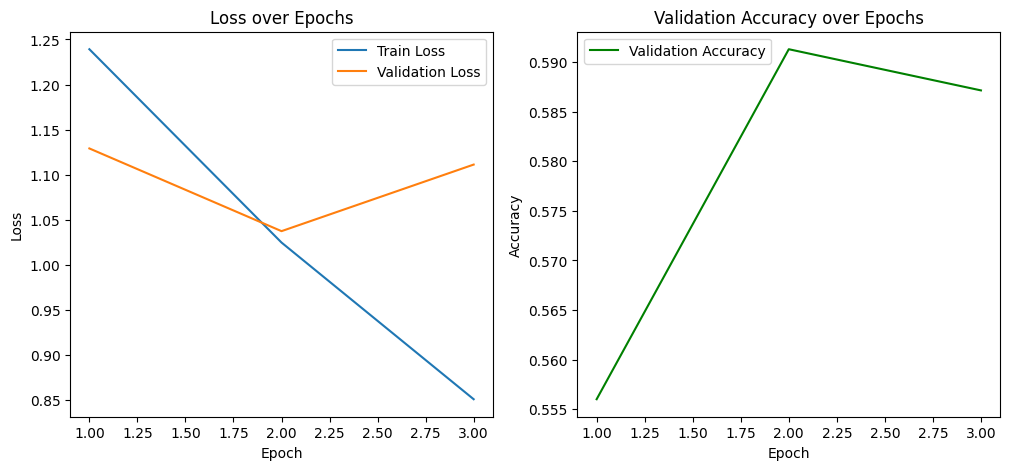

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)

train_losses = []
val_accuracies = []
val_losses = []

model.train()
num_epochs=3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids, attention_mask, labels = [x.to(model.device) for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    true_labels = []
    pred_labels = []
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            input_ids, attention_mask, labels = [x.to(model.device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            
            logits = outputs.logits
            preds = torch.argmax(logits, axis=1)
            pred_labels.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    accuracy = accuracy_score(true_labels, pred_labels)
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {accuracy:.4f}")

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.show()


In [ ]:
model.eval()

true_labels = []
predictions = []

with torch.no_grad():  # No need to track gradients
    for batch in tqdm(val_loader, desc="Evaluating"):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(model.device)
        attention_mask = attention_mask.to(model.device)
        labels = labels.to(model.device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        
        logits = outputs.logits
        pred_labels = torch.argmax(logits, axis=1)
        
        predictions.extend(pred_labels.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Evaluating: 100%|██████████| 91/91 [00:04<00:00, 18.65it/s]

Accuracy: 0.5871
Precision: 0.6282
Recall: 0.5819
F1 Score: 0.5795


In [ ]:
save_directory = '/kaggle/working/vibert-base-cased'
os.makedirs(save_directory, exist_ok=True)

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to /kaggle/working/vibert-base-cased


In [22]:
model = AutoModelForSequenceClassification.from_pretrained('/kaggle/working/vibert-base-cased')
tokenizer = AutoTokenizer.from_pretrained('/kaggle/working/vibert-base-cased')

In [23]:
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
}, os.path.join(save_directory, 'training_checkpoint.pth'))

In [24]:
checkpoint = torch.load('/kaggle/working/vibert-base-cased/training_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']

In [25]:
# Mapping label để hiển thị dễ hiểu (bạn chỉnh sửa nếu cần)
label_names = {
    0: 'Vui vẻ',
    1: 'Tức giận',
    2: 'Buồn bã',
    3: 'Sợ hãi',
    4: 'Trung lập'
}

In [ ]:
print("\n--- Examples of Predictions ---")
for i in range(10):
    pred = predictions[i]
    true = true_labels[i]
    text = comments.iloc[val_dataset.indices[i]]['text']
    status = "✅ Correct" if pred == true else "❌ Incorrect"
    print(f"{status} | Text: {text}\n  Predicted: {label_names[pred]}, Actual: {label_names[true]}\n")

correct = [(p, t, comments.iloc[val_dataset.indices[i]]['text']) 
           for i, (p, t) in enumerate(zip(predictions, true_labels)) if p == t]
incorrect = [(p, t, comments.iloc[val_dataset.indices[i]]['text']) 
             for i, (p, t) in enumerate(zip(predictions, true_labels)) if p != t]

print(f"Tổng số đúng: {len(correct)}")
print(f"Tổng số sai: {len(incorrect)}")



--- Examples of Predictions ---
✅ Correct | Text: thương tr
  Predicted: Buồn bã, Actual: Buồn bã

❌ Incorrect | Text: xe dập lửa
  Predicted: Tức giận, Actual: Trung lập

✅ Correct | Text: chả j cg phá
  Predicted: Tức giận, Actual: Tức giận

❌ Incorrect | Text: ê đi xét_nghiệm thử sợ mấy hiv trả_thù đời lắm
  Predicted: Tức giận, Actual: Sợ hãi

❌ Incorrect | Text: từ_từ chân rớt bây_giờ
  Predicted: Buồn bã, Actual: Sợ hãi

✅ Correct | Text: sợ đấy
  Predicted: Sợ hãi, Actual: Sợ hãi

✅ Correct | Text: rung dọa khỉ
  Predicted: Trung lập, Actual: Trung lập

❌ Incorrect | Text: đi mấy cháu cơ_hội trở ta cơ_hội
  Predicted: Tức giận, Actual: Buồn bã

✅ Correct | Text: vãi ò
  Predicted: Tức giận, Actual: Tức giận

❌ Incorrect | Text: v đảm_bảo đỗ nguyện_vọng 1 cộng_điểm
  Predicted: Vui vẻ, Actual: Trung lập

Tổng số đúng: 849
Tổng số sai: 597


In [ ]:
def predict_text(text):
    model.eval()
    text = preprocess_text(text)
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        padding='max_length',
        max_length=64,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoded['input_ids'].to(model.device)
    attention_mask = encoded['attention_mask'].to(model.device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    print(f"\n🔮 Dự đoán cảm xúc: {label_names[predicted_class]}")

In [ ]:
user_input = "nghe bạn nam bảo : khổ thế nhờ đã dịch cô vít thì chớ mà xót🥺"
print(user_input)
predict_text(user_input)

nghe bạn nam bảo : khổ thế nhờ đã dịch cô vít thì chớ mà xót🥺

🔮 Dự đoán cảm xúc: Buồn bã
